In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [3]:
#df = pd.read_csv("../Data/Raw/new_approach/Weekly_Covid_Data_Population_Normalized.csv")
df = pd.read_csv("../Data/Raw/new_approach/Weekly_Covid_Data.csv")

In [4]:
print(df.columns)
print(df.shape)

Index(['week_no', 'iso_code', 'new_cases', 'new_deaths', 'new_vaccinations',
       'new_people_vaccinated', 'reproduction_rate', 'stringency_index',
       'excess_mortality', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'cardiovasc_death_rate', 'diabetes_prevalence',
       'female_smokers', 'male_smokers', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index', 'population'],
      dtype='object')
(41184, 21)


In [5]:

df.drop(["iso_code", "week_no"], axis=1, inplace=True)
#df.drop(columns=df.columns[0:1], axis=1, inplace=True)
pop = df.iloc[0]["population"]
last_country = df.iloc[234*176 - 1]
print(last_country)
cnt = df["population"].value_counts()

new_cases                     7.500000e+01
new_deaths                    2.000000e+00
new_vaccinations              0.000000e+00
new_people_vaccinated         0.000000e+00
reproduction_rate             9.500000e-01
stringency_index              8.796000e+01
excess_mortality             -1.000000e+03
population_density            4.272900e+01
median_age                    1.960000e+01
aged_65_older                 2.822000e+00
aged_70_older                 1.882000e+00
cardiovasc_death_rate         3.078460e+02
diabetes_prevalence           1.820000e+00
female_smokers                1.600000e+00
male_smokers                  3.070000e+01
hospital_beds_per_thousand    1.700000e+00
life_expectancy               6.149000e+01
human_development_index       5.710000e-01
population                    1.632054e+07
Name: 41183, dtype: float64


In [7]:
# Here we are going to normalize the data.
from sklearn import preprocessing

x = df.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
#x_scaled = (x)
df = pd.DataFrame(x_scaled)

In [8]:
# now we want to join datas together
prediction_days_count = 2
features_list = []
X_list = []
Y_list = []
for i in range(234): # 234 is number of countries
    for j in range(176): # 176 is number of weeks we have
        row_list = df.loc[i*176 + j, :].values.flatten().tolist()
        features_list.append(row_list)
# print(len(features_list))
# print((len(features_list) - prediction_days_count) + 1)
for i in range((len(features_list) - prediction_days_count) + 1):
    fl = features_list[i]
    fl_len = len(features_list[i])
    this_population = features_list[i][fl_len - 1]
    for j in range(1, prediction_days_count):
        if this_population == features_list[i + j][fl_len - 1]:
            fl.extend(features_list[i + j])
        else:
            this_population = -1
            break
    if this_population != -1:
        X_list.append(fl)
        Y_list.append(features_list[(i + prediction_days_count) - 1][0])


In [9]:
print(len(X_list))
print(len(Y_list))
np.shape(X_list)

40950
40950


(40950, 38)

In [10]:
import math
def train_test_splitter(X, Y, prediction_days_count, batch_count, batch_length):
    xlen = len(X)
    xs_count_for_each_country = int(xlen / 234)
    X_train = []
    X_test = []
    Y_train = []
    Y_test = []
    steps = math.floor((xs_count_for_each_country - (batch_count * batch_length)) / (batch_count + 1)) 
    i = 0
    #print(steps)
    for i in range(234):
        j = 0
        for j in range((i * xs_count_for_each_country),(i * xs_count_for_each_country) + steps):
            X_train.append(X[j])
        #print(j)
            Y_train.append(Y[j])
        while(j + batch_length + steps < (i+1) * xs_count_for_each_country):
            for k in range(j + prediction_days_count, j + batch_length - prediction_days_count):
                X_test.append(X[k])
                Y_test.append(Y[k])
            j += batch_length
            for k in range(j, j + steps):
                X_train.append(X[k])
                Y_train.append(Y[k])
            j += steps + 1
            while j < (i+1) * xs_count_for_each_country:
                X_train.append(X[j])
                Y_train.append(Y[j])
                j += 1
        #print(j)
    ########
    # for i in range(steps):
    #     X_train.append(X[i])
    # while(i + batch_length + steps < xlen):
    #     for j in range(batch_length):
    #         X_test.append(X[j])
    #         Y_test.append(Y[j])
    #     for j in range(i, i + steps):
    #         X_train.append(X[j])
    #         Y_train.append(Y[j])
    #     i += batch_length + steps
    return X_train, X_test, Y_train, Y_test
        

In [11]:
X_train, X_test, Y_train, Y_test = train_test_splitter(X_list, Y_list, prediction_days_count, 3, 10)


In [12]:
print(np.shape(X_train), np.shape(X_test), np.shape(Y_train), np.shape(Y_test))

(38610, 38) (1404, 38) (38610,) (1404,)


# Modelling

## Importing loss functions

In [13]:
#from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error, mean_absolute_error, d2_tweedie_score


## SVR

In [14]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import SVR

In [29]:
svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
svr_lin = SVR(kernel="linear", C=100, gamma="auto")
svr_poly = SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)


In [30]:
svrs = [svr_rbf, svr_lin, svr_poly]
#kernel_label = ["RBF", "Linear", "Polynomial"]
#model_color = ["m", "c", "g"]

X_tr = np.array(X_train)
y_tr = np.array(Y_train)
X_te = np.array(X_test)
y_te = np.array(Y_test)

for svr in (svrs):
    y_pred= svr.fit(X_tr, y_tr).predict(X_te)
    svr_score = svr_rbf.score( X_te, y_pred)

    
    mae = mean_absolute_error(y_te , y_pred)
    mape = mean_absolute_percentage_error(y_te , y_pred)
    rmse = root_mean_squared_error(y_te , y_pred)
    tweedie = d2_tweedie_score(y_te , y_pred , power=1)

    print(f"score of {svr}:" , svr_score)
    print(f"mae of {svr}:" , mae)
    print(f"mape of {svr}:" , mape)
    print(f"rmse of {svr}:" , rmse)
    print(f"tweedie of {svr}:" , tweedie)
    print()


score of SVR(C=100, gamma=0.1): 1.0
mae of SVR(C=100, gamma=0.1): 0.08909941529677921
mape of SVR(C=100, gamma=0.1): 63411978025413.76
rmse of SVR(C=100, gamma=0.1): 0.08929711023567953
tweedie of SVR(C=100, gamma=0.1): -145.29961043918627

score of SVR(C=100, gamma='auto', kernel='linear'): 0.33192547971614517
mae of SVR(C=100, gamma='auto', kernel='linear'): 0.0902394326403489
mape of SVR(C=100, gamma='auto', kernel='linear'): 64420230976992.94
rmse of SVR(C=100, gamma='auto', kernel='linear'): 0.09038439000188758
tweedie of SVR(C=100, gamma='auto', kernel='linear'): -147.17767758673466

score of SVR(C=100, coef0=1, gamma='auto', kernel='poly'): -0.14448818735022195
mae of SVR(C=100, coef0=1, gamma='auto', kernel='poly'): 0.09239859263126042
mape of SVR(C=100, coef0=1, gamma='auto', kernel='poly'): 65288227794707.4
rmse of SVR(C=100, coef0=1, gamma='auto', kernel='poly'): 0.09250036004267681
tweedie of SVR(C=100, coef0=1, gamma='auto', kernel='poly'): -150.7551249126501



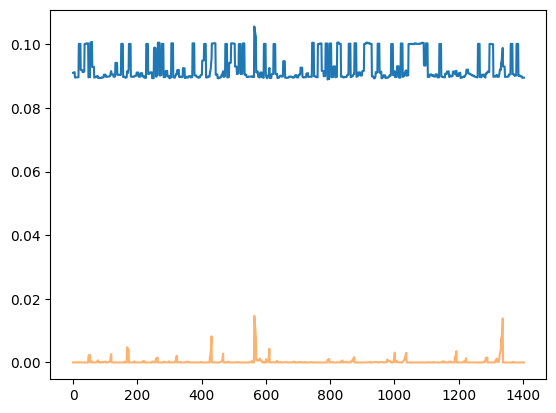

In [31]:
plt.plot(np.arange(len(y_pred)) , y_pred)
plt.plot(np.arange(len(y_pred)) , y_te , alpha = .6)

plt.show()

## KNN

In [32]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=2 , p = 2)
neigh.fit(X_tr, y_tr)
y_pred = neigh.predict(X_te)

mae = mean_absolute_error(y_te , y_pred)
mape = mean_absolute_percentage_error(y_te , y_pred)
rmse = root_mean_squared_error(y_te , y_pred)
#tweedie = d2_tweedie_score(y_te , y_pred , power=1)

print(f"mae  :" , mae)
print(f"mape :" , mape)
print(f"rmse :" , rmse)
#print(f"tweedie power 1 :" , tweedie)


mae  : 0.00011794806701115033
mape : 2530341915.3062997
rmse : 0.0004077662931835461


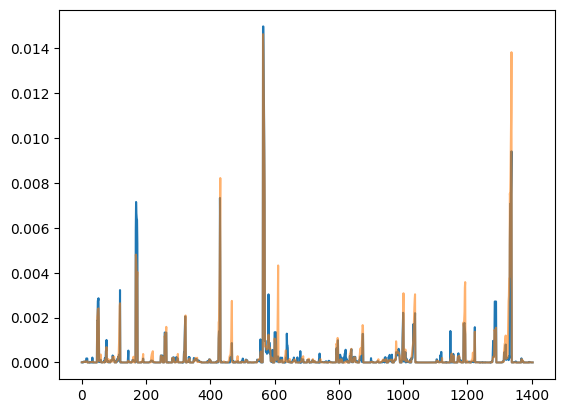

In [33]:
plt.plot(np.arange(len(y_pred)) , y_pred)
plt.plot(np.arange(len(y_pred)) , y_te , alpha = .6)

plt.show()

## Polynomial

In [34]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)
poly.fit_transform(X_train)
poly = PolynomialFeatures(interaction_only=True)
poly.fit_transform(X_tr)

mae = mean_absolute_error(y_te , y_pred)
mape = mean_absolute_percentage_error(y_te , y_pred)
rmse = root_mean_squared_error(y_te , y_pred)
#tweedie = d2_tweedie_score(y_te , y_pred , power=1)

print(f"mae  :" , mae)
print(f"mape :" , mape)
print(f"rmse :" , rmse)
#print(f"tweedie power 1 :" , tweedie)

mae  : 0.00011794806701115033
mape : 2530341915.3062997
rmse : 0.0004077662931835461


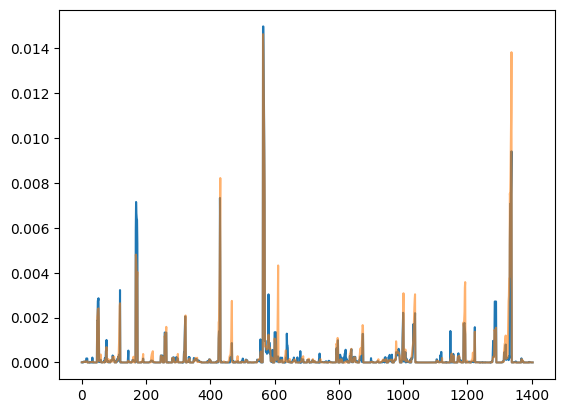

In [35]:
plt.plot(np.arange(len(y_pred)) , y_pred)
plt.plot(np.arange(len(y_pred)) , y_te , alpha = .6)

plt.show()

## AdaBoost

In [36]:
from sklearn.ensemble import AdaBoostRegressor
#from sklearn.datasets import make_regression

regr = AdaBoostRegressor(random_state=0, n_estimators=100)
regr.fit(X_tr, y_tr)
y_pred = regr.predict(X_te)

mae = mean_absolute_error(y_te , y_pred)
mape = mean_absolute_percentage_error(y_te , y_pred)
rmse = root_mean_squared_error(y_te , y_pred)
tweedie = d2_tweedie_score(y_te , y_pred , power=1)

print(f"mae  :" , mae)
print(f"mape :" , mape)
print(f"rmse :" , rmse)
print(f"tweedie power 1 :" , tweedie)

mae  : 0.0005314413034238391
mape : 337697827419.43304
rmse : 0.0007053772320550639
tweedie power 1 : 0.2485598871534599


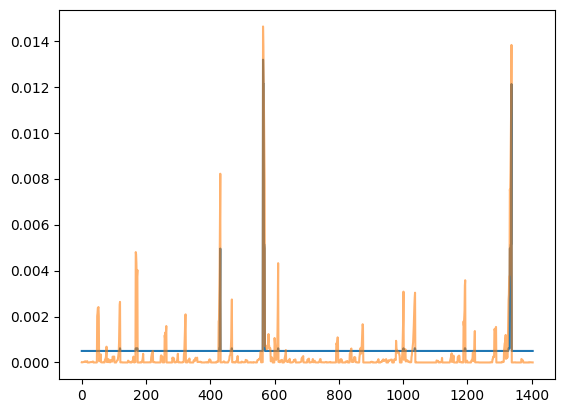

In [37]:
plt.plot(np.arange(len(y_pred)) , y_pred)
plt.plot(np.arange(len(y_pred)) , y_te , alpha = .6)

plt.show()

## Random Forest

In [38]:
from sklearn.ensemble import RandomForestRegressor
#from sklearn.datasets import make_regression

regr = RandomForestRegressor(max_depth=4, random_state=0)
regr.fit(X_tr, y_tr)
y_pred = regr.predict(X_te)
regr.score(X_te, y_pred)


mae = mean_absolute_error(y_te , y_pred)
mape = mean_absolute_percentage_error(y_te , y_pred)
rmse = root_mean_squared_error(y_te , y_pred)
tweedie = d2_tweedie_score(y_te , y_pred , power=1)

print(f"mae  :" , mae)
print(f"mape :" , mape)
print(f"rmse :" , rmse)
print(f"tweedie power 1 :" , tweedie)

mae  : 0.0001028976814513297
mape : 48518690116.25003
rmse : 0.00016093443945136126
tweedie power 1 : 0.8938006385600833


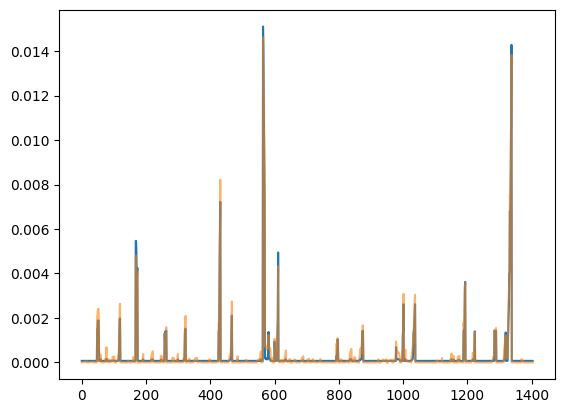

In [39]:
plt.plot(np.arange(len(y_pred)) , y_pred)
plt.plot(np.arange(len(y_pred)) , y_te , alpha = .6)

plt.show()

## Stacking

In [40]:
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor

estimators = [
    ('lr', RidgeCV()),
    ('svr', LinearSVR(dual="auto", random_state=42))
]
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=10,
                                          random_state=42)
)

y_pred = reg.fit(X_tr, y_tr).predict(X_te)


mae = mean_absolute_error(y_te , y_pred)
mape = mean_absolute_percentage_error(y_te , y_pred)
rmse = root_mean_squared_error(y_te , y_pred)
#tweedie = d2_tweedie_score(y_te , y_pred , power=1)

print(f"mae  :" , mae)
print(f"mape :" , mape)
print(f"rmse :" , rmse)
#print(f"tweedie power 1 :" , tweedie)

C:\Users\hafez\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\hafez\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


mae  : 4.627225299693179e-06
mape : 2243578083.790816
rmse : 1.2091461024439248e-05


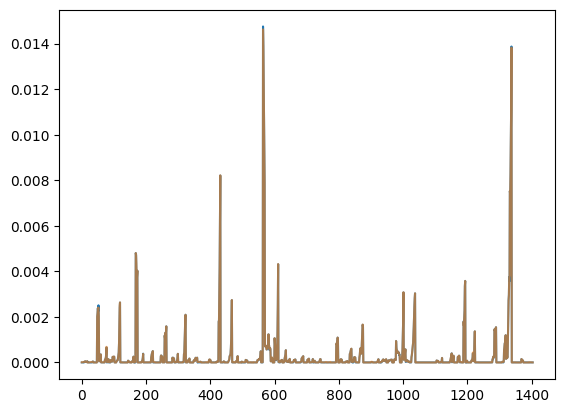

In [41]:
plt.plot(np.arange(len(y_pred)) , y_pred)
plt.plot(np.arange(len(y_pred)) , y_te , alpha = .6)

plt.show()

# TEST

In [42]:
# ns_list, train_scores, validation_scores = learning_curve(
#                                                    estimator = SVR(**opt_svr_param), 
#                                                    X = X, y = Y, 
#                                                    train_sizes = ns_list, cv = 5,
#                                                    scoring = 'neg_mean_squared_error')


In [43]:
# train_scores, valid_scores = validation_curve(KNeighborsRegressor(), X, Y, 
#                                               param_name="n_neighbors",
#                                               param_range=k_list , cv=20, 
#                                               scoring = 'neg_mean_squared_error',
#                                               verbose=1, n_jobs=-1
#                                              )
